<a href="https://colab.research.google.com/github/jdilger/TensorFlowNotebooks/blob/master/Pools_to_Fuels_FM40_multilabel_multiclass_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pools to Fuels: Neural Networks FM40 modeling

Package Installation

In [1]:
# import installed packages
import math
import json
import subprocess
import numpy as np
import math
import folium
from folium import plugins
from pprint import pprint
print(folium.__version__)

%pylab inline

0.8.3
Populating the interactive namespace from numpy and matplotlib


In [2]:
!nvidia-smi

Wed Mar  2 16:13:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Google Earth Engine installation and authentication

In [3]:
!pip install earthengine-api -q 

In [4]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive

In [5]:
import ee

ee.Authenticate()
ee.Initialize()

# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'


# Test the earthengine command by getting help on upload.
#!earthengine upload image -h

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=6wzgYmYZfH8IccxgKSx2QjXs4Ymhk77ykTyPjy_ejN8&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWi_kMgS8juY-PgIWGvSFSTXRKafVMBcWFD28zBaiGAIhAjypDMt4fk

Successfully saved authorization token.


TensorFlow imports

In [6]:
import tensorflow as tf
print(tf.__version__)

2.8.0


Fuel Layers from Pyregence GEE assets

In [51]:
# label(s)
# categorical

# 0 - 45
CBD = ee.Image('projects/pyregence-ee/assets/conus/fuels/Fuels_CBD_2021_12').rename('CBD').int64()
CBD = CBD.updateMask(CBD.neq(-9999))

# 0 - 45
CBH = ee.Image('projects/pyregence-ee/assets/conus/fuels/Fuels_CBH_2021_12').rename('CBH').int64()
CBH = CBH.updateMask(CBH.neq(-9999))

# 0 - 100
CC = ee.Image('projects/pyregence-ee/assets/conus/fuels/Fuels_CC_2021_12').rename('CC').int64()
CC = CC.updateMask(CC.neq(-9999))
remap_cc_from = [0,5,15,17,25,35,42,45,55,65,75,80,85,95]
remap_cc_to = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
CC = CC.remap(remap_cc_from,remap_cc_to).rename('CC')

# 0 - 510
CH = ee.Image('projects/pyregence-ee/assets/conus/fuels/Fuels_CH_2021_12').rename('CH').int64()
CH = CH.updateMask(CH.neq(-9999))
# test remapping to lower total number of classes
remap_from = [0,30,70,110,150,190,230,270,310,350,390,430,470,510]
remap_to = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
CH = CH.remap(remap_from,remap_to).rename('CH')

# 45 classes
FM40_WUI = ee.Image('projects/pyregence-ee/assets/conus/fuels/Fuels_FM40_2021_12').rename('FM40_WUI').int64()
remap_from_fm = [91,92,93,98,99,101,102,103,104,105,106,107,108,109,121,122,123,124,141,142,143,144,145,146,147,148,149,161,162,163,164,165,181,182,183,184,185,186,187,188,189,201,202,203,204]
remap_to_fm =  [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44]
FM40_WUI = FM40_WUI.remap(remap_from_fm,remap_to_fm).rename('FM40_WUI')

counties = ee.FeatureCollection('projects/pyregence-ee/assets/lucas/cb_2020_us_county_500k')
EVT_coll = ee.ImageCollection('projects/pyregence-ee/assets/conus/landfire/evt')

LABEL_MIN_MAX = {
    'CBD_min': 0,
    'CBD_max': 45,
    'CBH_min': 0,
    'CBH_max': 45,
    'CC_min': 0,
    'CC_max': 13,
    'CH_min': 0,
    'CH_max': 13,
    'FM40_WUI_min': 0,
    'FM40_WUI_max': 45,
}

FEATURES_MIN_MAX_CONTINUOUS = {
    # features
    # continuous
    'agfast_min': 0,
    'agfast_max': 94.37110137939453,
    'agmed_min': 0,
    'agmed_max': 101.16639709472656,
    'agslo_min': 0,
    'agslo_max': 86.55889892578125,
    'agvfast_min': -0.3476000130176544,
    'agvfast_max': 15.683699607849121,
    'bgfast_min': 0,
    'bgfast_max': 35.17770004272461,
    'bgslo_min': 0,
    'bgslo_max': 303.1913146972656,
    'bgvfast_min': -0.08510000258684158,
    'bgvfast_max': 1.5648000240325928,
    'croot_min': 0,
    'croot_max': 86.0250015258789,
    'froot_min': 0,
    'froot_max': 6.674200057983398,
    'foliage_min': 0,
    'foliage_max': 20.690799713134766,
    'merch_min': 0,
    'merch_max': 334.8053894042969,
    'otherw_min': 0,
    'otherw_max': 66.0457992553711,
    'snbran_min': 0,
    'snbran_max': 37.233299255371094,
    'snstem_min': 0,
    'snstem_max': 334.8721923828125,
}

Pools Layers from Pyregence GEE assets

In [52]:
# features
# continuous

agfast = ee.Image('projects/pyregence-ee/assets/lucas/conus/Aboveground-Fast_2022_02').rename('agfast').float()
# scaling
agfast = agfast.subtract(FEATURES_MIN_MAX_CONTINUOUS['agfast_min']).divide(ee.Image(FEATURES_MIN_MAX_CONTINUOUS['agfast_max']).subtract(ee.Image(FEATURES_MIN_MAX_CONTINUOUS['agfast_min'])))
agfast = agfast.updateMask(agfast.gte(0).And(agfast.lte(1)))

agmed = ee.Image('projects/pyregence-ee/assets/lucas/conus/Aboveground-Medium_2022_02').rename('agmed').float()
agmed = agmed.subtract(FEATURES_MIN_MAX_CONTINUOUS['agmed_min']).divide(ee.Image(FEATURES_MIN_MAX_CONTINUOUS['agmed_max']).subtract(ee.Image(FEATURES_MIN_MAX_CONTINUOUS['agmed_min'])))
agmed = agmed.updateMask(agmed.gte(0).And(agmed.lte(1)))

agslo = ee.Image('projects/pyregence-ee/assets/lucas/conus/Aboveground-Slow_2022_02').rename('agslo').float()
agslo = agslo.subtract(FEATURES_MIN_MAX_CONTINUOUS['agslo_min']).divide(ee.Image(FEATURES_MIN_MAX_CONTINUOUS['agslo_max']).subtract(ee.Image(FEATURES_MIN_MAX_CONTINUOUS['agslo_min'])))
agslo = agslo.updateMask(agslo.gte(0).And(agslo.lte(1)))

agvfast = ee.Image('projects/pyregence-ee/assets/lucas/conus/Aboveground-Very-Fast_2022_02').rename('agvfast').float()
agvfast = agvfast.subtract(FEATURES_MIN_MAX_CONTINUOUS['agvfast_min']).divide(ee.Image(FEATURES_MIN_MAX_CONTINUOUS['agvfast_max']).subtract(ee.Image(FEATURES_MIN_MAX_CONTINUOUS['agvfast_min'])))
agvfast = agvfast.updateMask(agvfast.gte(0).And(agvfast.lte(1)))

bgfast = ee.Image('projects/pyregence-ee/assets/lucas/conus/Belowground-Fast_2022_02').rename('bgfast').float()
bgfast = bgfast.subtract(FEATURES_MIN_MAX_CONTINUOUS['bgfast_min']).divide(ee.Image(FEATURES_MIN_MAX_CONTINUOUS['bgfast_max']).subtract(ee.Image(FEATURES_MIN_MAX_CONTINUOUS['bgfast_min'])))
bgfast = bgfast.updateMask(bgfast.gte(0).And(bgfast.lte(1)))

bgslo = ee.Image('projects/pyregence-ee/assets/lucas/conus/Belowground-Slow_2022_02').rename('bgslo').float()
bgslo = bgslo.subtract(FEATURES_MIN_MAX_CONTINUOUS['bgslo_min']).divide(ee.Image(FEATURES_MIN_MAX_CONTINUOUS['bgslo_max']).subtract(ee.Image(FEATURES_MIN_MAX_CONTINUOUS['bgslo_min'])))
bgslo = bgslo.updateMask(bgslo.gte(0).And(bgslo.lte(1)))

bgvfast = ee.Image('projects/pyregence-ee/assets/lucas/conus/Belowground-Very-Fast_2022_02').rename('bgvfast').float()
bgvfast = bgvfast.subtract(FEATURES_MIN_MAX_CONTINUOUS['bgvfast_min']).divide(ee.Image(FEATURES_MIN_MAX_CONTINUOUS['bgvfast_max']).subtract(ee.Image(FEATURES_MIN_MAX_CONTINUOUS['bgvfast_min'])))
bgvfast = bgvfast.updateMask(bgvfast.gte(0).And(bgvfast.lte(1)))

croot = ee.Image('projects/pyregence-ee/assets/lucas/conus/Coarse-Roots_2022_02').rename('croot').float()
croot = croot.subtract(FEATURES_MIN_MAX_CONTINUOUS['croot_min']).divide(ee.Image(FEATURES_MIN_MAX_CONTINUOUS['croot_max']).subtract(ee.Image(FEATURES_MIN_MAX_CONTINUOUS['croot_min'])))
croot = croot.updateMask(croot.gte(0).And(croot.lte(1)))

froot = ee.Image('projects/pyregence-ee/assets/lucas/conus/Fine-Roots_2022_02').rename('froot').float()
froot = froot.subtract(FEATURES_MIN_MAX_CONTINUOUS['froot_min']).divide(ee.Image(FEATURES_MIN_MAX_CONTINUOUS['froot_max']).subtract(ee.Image(FEATURES_MIN_MAX_CONTINUOUS['froot_min'])))
froot = froot.updateMask(froot.gte(0).And(froot.lte(1)))

foliage = ee.Image('projects/pyregence-ee/assets/lucas/conus/Foliage_2022_02').rename('foliage').float()
foliage = foliage.subtract(FEATURES_MIN_MAX_CONTINUOUS['foliage_min']).divide(ee.Image(FEATURES_MIN_MAX_CONTINUOUS['foliage_max']).subtract(ee.Image(FEATURES_MIN_MAX_CONTINUOUS['foliage_min'])))
foliage = foliage.updateMask(foliage.gte(0).And(foliage.lte(1)))

merch = ee.Image('projects/pyregence-ee/assets/lucas/conus/Merchantable_2022_02').rename('merch').float()
merch = merch.subtract(FEATURES_MIN_MAX_CONTINUOUS['merch_min']).divide(ee.Image(FEATURES_MIN_MAX_CONTINUOUS['merch_max']).subtract(ee.Image(FEATURES_MIN_MAX_CONTINUOUS['merch_min'])))
merch = merch.updateMask(merch.gte(0).And(merch.lte(1)))

otherw = ee.Image('projects/pyregence-ee/assets/lucas/conus/Other-Wood_2022_02').rename('otherw').float()
otherw = otherw.subtract(FEATURES_MIN_MAX_CONTINUOUS['otherw_min']).divide(ee.Image(FEATURES_MIN_MAX_CONTINUOUS['otherw_max']).subtract(ee.Image(FEATURES_MIN_MAX_CONTINUOUS['otherw_min'])))
otherw = otherw.updateMask(otherw.gte(0).And(otherw.lte(1)))

snbran = ee.Image('projects/pyregence-ee/assets/lucas/conus/Snag-Branch_2022_02').rename('snbran').float()
snbran = snbran.subtract(FEATURES_MIN_MAX_CONTINUOUS['snbran_min']).divide(ee.Image(FEATURES_MIN_MAX_CONTINUOUS['snbran_max']).subtract(ee.Image(FEATURES_MIN_MAX_CONTINUOUS['snbran_min'])))
snbran = snbran.updateMask(snbran.gte(0).And(snbran.lte(1)))

snstem = ee.Image('projects/pyregence-ee/assets/lucas/conus/Snag-Stem_2022_02').rename('snstem').float()
snstem = snstem.subtract(FEATURES_MIN_MAX_CONTINUOUS['snstem_min']).divide(ee.Image(FEATURES_MIN_MAX_CONTINUOUS['snstem_max']).subtract(ee.Image(FEATURES_MIN_MAX_CONTINUOUS['snstem_min'])))
snstem = snstem.updateMask(snstem.gte(0).And(snstem.lte(1)))



# remove this
# last_dist = ee.Image('projects/pyregence-ee/assets/lucas/conus/Recent-Disturbance-Masked_2022_02').rename('ldist').float()

# categorical
# not using now
# stateclass = ee.Image('projects/pyregence-ee/assets/lucas/conus/stateclass_onlyforest').rename('sclass').float()
# evt = ee.Image('projects/pyregence-ee/assets/conus/landfire/evt/LF2016_EVT_200').rename('evt').float()
# age = ee.Image('projects/pyregence-ee/assets/lucas/conus/Age-Class_2022_02').rename('age').float()


Topographic Layers from GEE

In [53]:
srtm = ee.Image('USGS/SRTMGL1_003')
elevation = srtm.select('elevation').float()
slope = ee.Terrain.slope(elevation).float()
aspect = ee.Terrain.aspect(elevation).float()


In [54]:
# Area of Interest - 20 counties

county_list = counties.filter(ee.Filter.inList('GEOID', 
          ee.List(["30013", "41029", "06069", "23011", "41003", 
                    "53041", "53037", "01037", "06043", "08007", 
                    "16015", "16035", "21131", "29179", "36113", 
                    "40081", "45041", "48259", "49051", "55099"])));


Data stacking and sampling



In [55]:
# Cloud Storage bucket into which training, testing and prediction 
# datasets will be written.  You must be able to write into this bucket.
OUTPUT_BUCKET = 'pools2fuels'

# Data for predictors.
carbon_bands = agfast.addBands(agmed).addBands(agslo).addBands(agvfast).addBands(bgfast).addBands(bgslo).addBands(bgvfast) \
                     .addBands(croot).addBands(froot).addBands(foliage).addBands(merch).addBands(otherw).addBands(snbran).addBands(snstem).addBands(aspect)

# ['CBD',	'CBH', 'CC', 'CH', 'FM40_WUI']
label_data = CBD.addBands(CBH).addBands(CC).addBands(CH).addBands(FM40_WUI)
all_data = carbon_bands.addBands(label_data)

# Use these bands for prediction.
# ['agfast', 'agmed', 'agslo', 'agvfast', 'bgfast', 'bgslo', 'bgvfast', 'croot', 'froot','foliage', 'merch','otherw','snbran','snstem','ldist','elevation', 'slope', 'aspect']
BANDS = carbon_bands.bandNames().getInfo()

# This is a trianing/testing dataset of points with known land cover labels.
# LABEL_DATA = ee.FeatureCollection('projects/pyregence-ee/assets/lucas/conus/fm40_sample_points_20counties')
LABEL_DATA = ee.FeatureCollection('users/bbhandari/FM40TrainingData')
# The labels, consecutive integer indices starting from zero, are stored in
# this property, set on each point.
# LABEL = 'FM40_WUI'
LABEL = ['CBD',	'CBH', 'CC', 'CH', 'FM40_WUI']

FEATURES = all_data.bandNames().getInfo()
print(len(FEATURES), FEATURES)

# File names for the training and testing datasets.  These TFRecord files
# will be exported from Earth Engine into the Cloud Storage bucket.
TRAIN_FILE_PREFIX = 'TrainingDataFM40_wo_jjd_45class' # without state, evt, last_dist and age
TEST_FILE_PREFIX = 'TestingDataFM40_wo_jjd_45class'
VAL_FILE_PREFIX = 'ValidationDataFM40_wo_jjd_45class'

file_extension = '.tfrecord.gz'
TRAIN_FILE_PATH = 'gs://' + OUTPUT_BUCKET + '/' + TRAIN_FILE_PREFIX + file_extension
TEST_FILE_PATH = 'gs://' + OUTPUT_BUCKET + '/' + TEST_FILE_PREFIX + file_extension
VAL_FILE_PATH = 'gs://' + OUTPUT_BUCKET + '/' + VAL_FILE_PREFIX + file_extension


20 ['agfast', 'agmed', 'agslo', 'agvfast', 'bgfast', 'bgslo', 'bgvfast', 'croot', 'froot', 'foliage', 'merch', 'otherw', 'snbran', 'snstem', 'aspect', 'CBD', 'CBH', 'CC', 'CH', 'FM40_WUI']


In [56]:
BATCH_SIZE = 32
EPOCHS = 50

N_CLASSES = 0
MAX_N_CLASS = 0
for label in LABEL:
    thisNClass = LABEL_MIN_MAX[f'{label}_max']
    N_CLASSES += thisNClass
    if thisNClass > MAX_N_CLASS:
        MAX_N_CLASS = thisNClass
N_CLASSES, MAX_N_CLASS

(158, 45)

In [57]:
# Sample the image at the points and add a random column.

sample = all_data.sample(
    region=LABEL_DATA,
    scale=30
).randomColumn()

# Partition the sample approximately 70-30.
training = sample.filter(ee.Filter.lt('random', 0.6))
train_size = training.size().getInfo()

testing = sample.filter(ee.Filter.And(ee.Filter.gte('random', 0.6), ee.Filter.lt('random', 0.85)))
test_size = testing.size().getInfo()

validation = sample.filter(ee.Filter.gte('random', 0.85))
validation_size = validation.size().getInfo()

In [30]:
print(train_size)

18590


In [58]:
# Create the tasks.
training_task = ee.batch.Export.table.toCloudStorage(
  collection=training,
  description='Training Export',
  fileNamePrefix=TRAIN_FILE_PREFIX,
  bucket=OUTPUT_BUCKET,
  fileFormat='TFRecord',
  selectors=FEATURES)

testing_task = ee.batch.Export.table.toCloudStorage(
  collection=testing,
  description='Testing Export',
  fileNamePrefix=TEST_FILE_PREFIX,
  bucket=OUTPUT_BUCKET,
  fileFormat='TFRecord',
  selectors=FEATURES)

validation_task = ee.batch.Export.table.toCloudStorage(
  collection=validation,
  description='Validation Export',
  fileNamePrefix=VAL_FILE_PREFIX,
  bucket=OUTPUT_BUCKET,
  fileFormat='TFRecord',
  selectors=FEATURES)

# Start the tasks.
training_task.start()
testing_task.start()
validation_task.start()

In [59]:
import time 
while training_task.active():
  print('Polling for task (id: {}).'.format(training_task.id))
  time.sleep(30)
print('Done with training export.')
while testing_task.active():
  print('Polling for task (id: {}).'.format(testing_task.id))
  time.sleep(30)
print('Done with testing export.')
while validation_task.active():
  print('Polling for task (id: {}).'.format(validation_task.id))
  time.sleep(30)
print('Done with validation export.')

Polling for task (id: AJRFQ6D3FNUZ6ZBVTZXOXJOH).
Polling for task (id: AJRFQ6D3FNUZ6ZBVTZXOXJOH).
Polling for task (id: AJRFQ6D3FNUZ6ZBVTZXOXJOH).
Done with training export.
Done with testing export.
Polling for task (id: NH3BXFENWDDYJ4PCS6OCUBCJ).
Done with validation export.


In [60]:
COLUMNS = [
  tf.io.FixedLenFeature(shape=[1], dtype=tf.float32) for k in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))


In [61]:
def parse_tfrecord(example_proto):
  """The parsing function.

  Read a serialized example into the structure defined by featuresDict.
  """

  return tf.io.parse_single_example(example_proto, FEATURES_DICT)


In [62]:
from tensorflow.keras import backend as K

# custom recall function
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# custom precision function
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# custom F1-score function
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# soft dice loss function
def dice_loss(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    true_sum = K.sum(K.square(y_true),-1) 
    pred_sum = K.sum(K.square(y_pred),-1)
    return 1 - ((2. * intersection + smooth) / (true_sum + pred_sum + smooth))

# define an adaptive learning rate based on training
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=500,
  decay_rate=1,
  staircase=False)

In [69]:
def to_tuple(inputs):
    predictors = [inputs.get(key) for key in BANDS]
    labels_dict = {}
    for key in LABEL: labels_dict[key] = tf.cast(inputs.get(key), tf.int32)
    _labels = [tf.one_hot(indices=labels_dict[key], depth=45) for key in labels_dict]
    return (tf.expand_dims(tf.transpose(predictors), 1), tf.stack(_labels, axis=1)) 


In [70]:
# Load datasets from the files.
train_dataset = tf.data.TFRecordDataset(TRAIN_FILE_PATH, compression_type='GZIP')
test_dataset = tf.data.TFRecordDataset(TEST_FILE_PATH, compression_type='GZIP')
val_dataset = tf.data.TFRecordDataset(VAL_FILE_PATH, compression_type='GZIP')

# Map the functions over the datasets to parse and convert to tuples.
train_dataset = train_dataset.map(parse_tfrecord, num_parallel_calls=4)
train_dataset = train_dataset.map(to_tuple, num_parallel_calls=4)
print(train_dataset)

train_dataset = train_dataset.shuffle(train_size).batch(BATCH_SIZE).repeat()

test_dataset = test_dataset.map(parse_tfrecord, num_parallel_calls=4)
test_dataset = test_dataset.map(to_tuple, num_parallel_calls=4)
test_dataset = test_dataset.batch(1).repeat()

val_dataset = val_dataset.map(parse_tfrecord, num_parallel_calls=4)
val_dataset = val_dataset.map(to_tuple, num_parallel_calls=4)
val_dataset = val_dataset.batch(1)

# Print the first parsed record to check.
from pprint import pprint
pprint(iter(test_dataset).next())

<ParallelMapDataset element_spec=(TensorSpec(shape=(1, 1, 15), dtype=tf.float32, name=None), TensorSpec(shape=(1, 5, 45), dtype=tf.float32, name=None))>
(<tf.Tensor: shape=(1, 1, 1, 15), dtype=float32, numpy=
array([[[[6.0859732e-02, 9.7575873e-02, 6.8407297e-01, 3.8217738e-01,
          2.5126714e-02, 5.4714102e-01, 4.0202436e-01, 1.4998198e-01,
          2.9199004e-01, 1.4921124e-01, 9.8985560e-02, 3.4790856e-01,
          3.1383198e-02, 3.5771858e-03, 2.1100806e+02]]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1, 5, 45), dtype=float32, numpy=
array([[[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0

In [71]:
# Define the layers in the model.
model = tf.keras.models.Sequential([
  tf.keras.layers.Input((1, 1, len(BANDS))),
  tf.keras.layers.Conv2D(64, (1, 1), activation='relu', name='conv2d_1'),
  tf.keras.layers.MaxPooling2D(2, padding='same', name='max_pool_1'),
  tf.keras.layers.Conv2D(128, (1, 1), activation='relu', name='conv2d_2'),
  tf.keras.layers.MaxPooling2D(2, padding='same', name='max_pool_2'),
  tf.keras.layers.Conv2D(256, (1, 1), activation='relu', name='conv2d_3'),
  tf.keras.layers.MaxPooling2D(2, padding='same', name='max_pool_3'),
  tf.keras.layers.Conv2D(512, (1, 1), activation='relu', name='conv2d_4'),
  tf.keras.layers.MaxPooling2D(2, padding='same', name='max_pool_4'),
  tf.keras.layers.Conv2D(1024, (1, 1), activation='relu', name='conv2d_5'),
  tf.keras.layers.MaxPooling2D(2, padding='same', name='max_pool_5'),
  tf.keras.layers.Conv2D(512, (1, 1), activation='relu', name='conv2d_6'),
  tf.keras.layers.MaxPooling2D(2, padding='same', name='max_pool_6'),
  tf.keras.layers.Conv2D(256, (1, 1), activation='relu', name='conv2d_7'),
  tf.keras.layers.MaxPooling2D(2, padding='same', name='max_pool_7'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1* len(LABEL) * MAX_N_CLASS , activation='sigmoid'),
  tf.keras.layers.Reshape((1, len(LABEL), MAX_N_CLASS))
])

# Compile the model with the specified loss function.
model.compile(
    # optimizer='rmsprop',
    optimizer=tf.keras.optimizers.Adam(lr_schedule),
    # loss=dice_loss,
    loss='categorical_crossentropy',#tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)
    metrics=[tf.keras.metrics.CategoricalCrossentropy(label_smoothing=0.2),'categorical_accuracy','accuracy', precision_m, recall_m, f1_m]
)


In [ ]:
print(model.summary())

In [67]:
EPOCHS = 50
BATCH_SIZE = 32

In [72]:
# Fit the model to the training data.
history = model.fit(x=train_dataset,
                    epochs=EPOCHS,
                    steps_per_epoch=(train_size // BATCH_SIZE),
                    validation_data=test_dataset,
                    validation_steps=test_size,
                   )

Epoch 1/50
569/569 [==============================] - 27s 41ms/step - loss: 1.6332 - categorical_crossentropy: 1.6332 - accuracy: 0.3577 - precision_m: 0.0605 - recall_m: 0.6211 - f1_m: 0.1097 - val_loss: 1.4551 - val_categorical_crossentropy: 1.4551 - val_accuracy: 0.3194 - val_precision_m: 0.0636 - val_recall_m: 0.5275 - val_f1_m: 0.1133
Epoch 2/50
569/569 [==============================] - 24s 42ms/step - loss: 1.4018 - categorical_crossentropy: 1.4018 - accuracy: 0.3349 - precision_m: 0.0681 - recall_m: 0.6231 - f1_m: 0.1227 - val_loss: 1.2877 - val_categorical_crossentropy: 1.2877 - val_accuracy: 0.3572 - val_precision_m: 0.0735 - val_recall_m: 0.6331 - val_f1_m: 0.1314
Epoch 3/50
569/569 [==============================] - 24s 42ms/step - loss: 1.3057 - categorical_crossentropy: 1.3057 - accuracy: 0.3538 - precision_m: 0.0708 - recall_m: 0.6223 - f1_m: 0.1272 - val_loss: 1.2923 - val_categorical_crossentropy: 1.2923 - val_accuracy: 0.3572 - val_precision_m: 0.0716 - val_recall_m: 

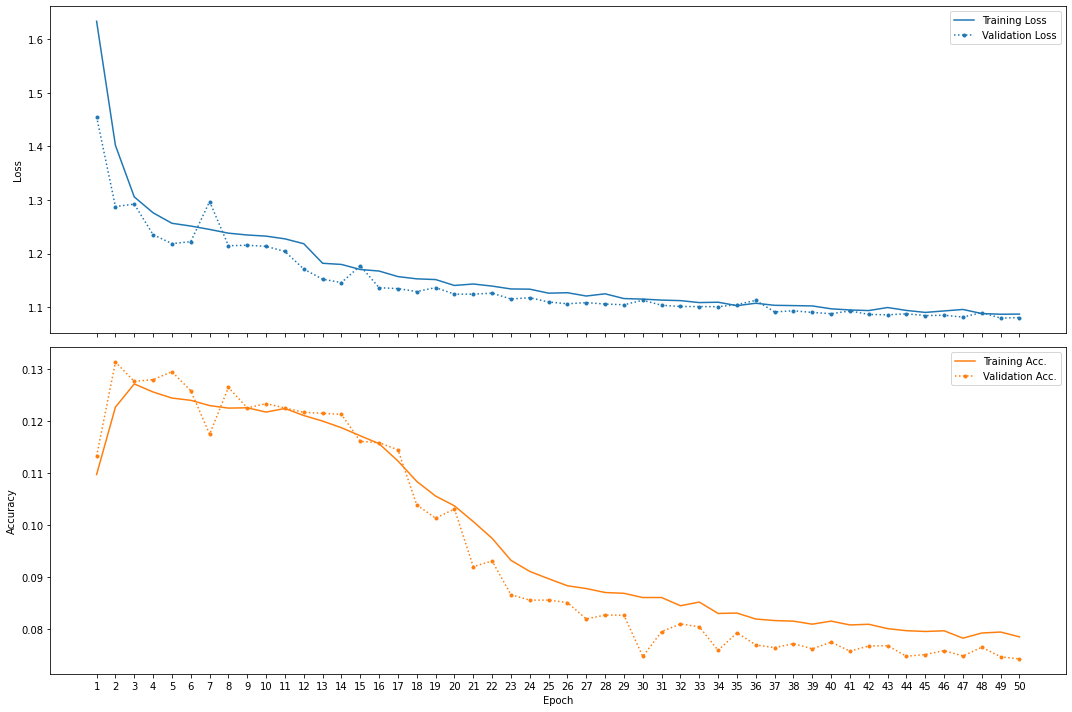

In [73]:
# plot the results of model training

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(15, 10))

ax[0].plot(history.history['loss'],color='#1f77b4',label='Training Loss')
ax[0].plot(history.history['val_loss'],linestyle=':',marker='o',markersize=3,color='#1f77b4',label='Validation Loss')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(history.history['f1_m'],color='#ff7f0e',label='Training Acc.')
ax[1].plot(history.history['val_f1_m'],linestyle=':',marker='o',markersize=3,color='#ff7f0e',label='Validation Acc.')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc="lower right")

ax[1].set_xticks(history.epoch)
ax[1].set_xticklabels(range(1,len(history.epoch)+1))
ax[1].set_xlabel('Epoch')

plt.legend()
plt.tight_layout()
plt.show()


In [65]:
# evaluate the model
model.evaluate(val_dataset)

4600/4600 [==============================] - 15s 3ms/step - loss: 2.9413 - categorical_crossentropy: 2.9413 - accuracy: 0.4034 - precision_m: 0.0104 - recall_m: 0.0026 - f1_m: 0.0042


[2.9412927627563477,
 2.9412920475006104,
 0.40343478322029114,
 0.01043478213250637,
 0.0026086957659572363,
 0.004173910710960627]

In [ ]:
# save the model as a TF Estimator which is what 
MODEL_NAME = 'fm40_multilable_multiclass_cnn'
TF_DIR = 'gs://{}/{}/'.format(BUCKET,MODEL_NAME)

# tf.keras.models.save_model(model,TF_DIR,save_format='tf')